# Projekt PRIAD

## Rozpoznawanie autora utworu literackiego na podstawie treści utworu z wykorzystaniem worka słów.

### Stanisław Maliński, Jan Stachurski

Importy

In [48]:
import os
import pandas as pd
import numpy as np
from math import log

In [49]:
import warnings
warnings.filterwarnings("ignore")

Wczytywanie danych

In [50]:
data_path = "./data/"
file_list = os.listdir(data_path)
func = lambda  a : a.replace(".txt", "").split("-")
count_size = lambda a : os.stat(a).st_size
data = [[func(title)[0], func(title)[1], data_path + title, count_size(data_path + title)] for title in file_list]
files = pd.DataFrame(data, columns=['Author', 'Name of The work', 'FilePath', 'FileSize'])

Przedstawiam zestaw uczący. Mamy tutaj pozycję kilku Polskich autorów.

In [51]:
print(files.drop(columns=['Name of The work', 'FilePath']).groupby('Author').sum())

                   FileSize
Author                     
AdamMickiewicz       784877
HenrykSienkiewicz   9138403
Juliusz Słowacki     329618


Wczytanie stop-słów:

In [52]:
def get_stop_words():
    delimeters = ["\\n", "'"]
    stop_words = []
    with open("./stopyPL.txt", encoding="utf8") as f:
        for line in f:
            word = repr(line)
            for c in delimeters:
                word = word.replace(c, "")
            stop_words.append(word)
    return stop_words

Projekt ten używa worka słów, który to przechowuje informacje na temat częstości występowania słów w danym dokumencie. Definiujemy tu dwie funckje jedna do standaryzacji słów tzn. usunięcia ewentualnych znaków graficznych takich jak kropka czy przecinek oraz ustawienie wielkości liter na małe aby słowa "Który" oraz "który" były zliczane jako to same słowo.
Druga funkcja służy do budowania worka słów. Zlicza najpierw pojedyńcze przypadki wystąpień, a następnie zlicza częstość wystąpień danego słowa.

In [53]:
special_char = [".", ",", "-", "?", "(", ")", "!", "\\", "\"", ":", ";", "*"]
def normalize_text(word):
    for char in special_char:
        word = word.replace(char, "")
    word = word.lower()
    return word

def get_text(FileName):
    out = ""
    n = 0
    with open(FileName, "r", encoding="utf8") as f:
        for line in f:
            out += line
            n += 1
        f.close()
    return (n, out)
        
# 0 - generete bag with all words, 1 - bag without stopwords, 2 - bag with only stopwords
stop_word = get_stop_words()
def generate_word_bag(text, mode=0):
    word_bag = {}
    words_in_bag = 0
    f = text.split("\n")
    set_w = set()
    for line in f:
        words = line.split()
        for word in words:
            if word != '':
                if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
                    words_in_bag += 1
                    if word in set_w:
                        word_bag[word]['Count'] += 1
                    else:
                        word_bag[word] = {'Count':1, 'Frequent':1, 'Is stop word': word in stop_word}
                        set_w.add(word)

    for word in word_bag.keys():
        word_bag[word]['Frequent'] = word_bag[word]['Count'] / words_in_bag
    return (word_bag, set_w)                                                        

In [54]:
file = files['FilePath'][0]
dictionary = generate_word_bag(get_text(file)[1])[0]
slowa = dictionary.keys()
slowo = list(slowa)[2]

print("W pliku: \"{}\" Słowo: \"{}\" występowało z częstością: {:.2e}".format(file, slowo, dictionary[slowo]['Frequent']))

W pliku: "./data/AdamMickiewicz-Ajudah.txt" Słowo: "poglądać" występowało z częstością: 1.09e-02


In [55]:
def head(dictionary, start=0, end=None, step=1, fname=None):
    words = list(dictionary.keys())
    if end is None:
        end = min(5, len(words))
    if fname is not None:
        print("W pliku\"{}\"".format(fname), ":")
    for word in words[start:end:step]:
        print("Słowo: \"{}\" występowało z częstością: {:.2e}".format(word,dictionary[word]['Frequent']), sep="")

In [56]:
file = files["FilePath"][1]
dictionary = generate_word_bag(get_text(file)[1], 2)[0]
head(dictionary, end=3, fname=file)

W pliku"./data/AdamMickiewicz-Ałuszta w dzień.txt" :
Słowo: "w" występowało z częstością: 2.17e-01
Słowo: "z" występowało z częstością: 2.17e-01
Słowo: "się" występowało z częstością: 1.74e-01


In [57]:
def show_most_frequent(dic, threshold=0):
    po_czestosci = dict(sorted(dic.items(), key=lambda x: int(x[1]['Count']), reverse = True))
    for index, word in enumerate(po_czestosci.keys()):
        if threshold == 0 and index < 10:
            print(word + " -> " + str(po_czestosci[word]['Count']))
        elif threshold == 0:
            break
        elif po_czestosci[word]['Count'] > threshold:
            print(word + " -> " + str(po_czestosci[word]['Count']))
        else:
            break

show_most_frequent(dictionary, 2)

w -> 5
z -> 5
się -> 4
i -> 4


Mamy już mały warsztat narzędzi do analizy utworów. Stworzymy teraz parę funckji, które pozwolą nam zgrabnie manipulować macierzą danych. 
merge_dics_to_df - łączy worki słów w ramkę danych, którą później wykorzystamy do nauki klasyfikatora.
tf_idf - analiza TF_IDF.

In [58]:
def merge_dics_to_df(dics_and_sets, labels=None, transform=lambda x:x):
    tab = []
    word_found = set()
    index = []
    for dic, _ in dics_and_sets:
        words = list(dic.keys())
        for word in words:
            if not word in word_found:
                word_found.add(word)
                index.append(word)
                rec = []
                for dictionary, set_w in dics_and_sets:
                    if word in set_w:
                        rec.append(transform(dictionary[word]))
                        del dictionary[word]
                        set_w.remove(word)
                    else:
                        rec.append(0)
                tab.append(rec)
    
    df = pd.DataFrame(tab, columns=labels, index=index)
    
    return df.T

In [59]:
def tfidf(data):
    df = data.copy()
    labels = data['labels']
    df = df.drop(columns=['labels'])
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    inbooks = np.array((df > 0)*1).sum(axis=0)
    idf = [log(nbooks / val, 10) for val in inbooks]
    tfidf = pd.DataFrame((tf*np.array([idf,]*nbooks)*100), columns=df.columns)
    tfidf['labels'] = labels
    return tfidf

In [60]:
def frequency(data):
    df = data.copy()
    labels = data['labels']
    df = df.drop(columns=['labels'])
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    fdf = pd.DataFrame(tf, columns=df.columns)
    fdf['labels'] = labels
    return fdf

In [61]:
def drop_threshold(df, threshold):
    to_drop = []
    labels = df['labels']
    df = df.drop(columns='labels')
    for col in df.columns:
        if (df[col] < threshold).all():
            to_drop.append(col)
    df = df.drop(columns=to_drop)
    df['labels'] = labels
    return df

Teraz musimy stworzyć model, który będzie klasyfikował do jakiego autora należy dany utwór.

Wczytanie i obliczenie słowników dla wszystkich utworów.

In [62]:
def load(files, mode=2):
    word_bags = []
    index = []
    labels = []

    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        n, cont = get_text(path)
        cont = normalize_text(cont)
        word_bags.append(generate_word_bag(cont, mode=mode))
        index.append(name)
        labels.append(label)
        
    df = merge_dics_to_df(word_bags, index, lambda x:x['Count'])
    df['labels'] = labels
        
    return df       

Połączenie wszystkich dzieł jednego autora w jeden wiersz w tabeli.

In [63]:
def merge_author(data):
    df = data.reset_index()
    df = df.drop(columns='index')
    newdf = pd.DataFrame(columns=df.columns)
    for index, row in df.iterrows():
        ind = newdf.index[newdf['labels']==row['labels']].tolist()
        if len(ind) == 0:
            newdf = newdf.append(row)
        else:
            label = row['labels']
            newdf.loc[ind[0],] += row
            newdf.loc[ind[0],'labels'] = label
    newdf = newdf.reset_index()
    newdf = newdf.drop(columns='index')
    return newdf

Jak widzimy mamy już ramkę danych, w której każdym obiektem jest dzieło a wektorem atrybutów jest częstość wystąpień poszczególnych słów w każdym z dzieł. Dodaliśmy również atrybuty decyzyjny czyli nazwisko autora danego dzieła.

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

import random

Metoda get_learning_data dzieli naszą macierz danych na dane uczące oraz testowe w pewnej proporcji. Dzięki temu będziemy mogli zweryfikować jak dobry nasz model jest.

In [121]:
# def get_learning_data(df, proporcja):
#     opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
#     return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}
def train_test_data(data, test_size=0.2, seed=None):
    if seed is not None:
        random.seed(seed)
    df = data.reset_index()
    df = df.drop(columns='index')
    ntest = int(df.shape[0] * test_size)
    testr = random.sample(range(df.shape[0]), ntest)
    return df.drop(testr).reset_index().drop(columns='index'), df.loc[testr].reset_index().drop(columns='index')

In [66]:
def weryfikuj(model, traind, testd, show=True):
    model.fit(traind.drop(columns='labels'), traind['labels'])
    wynik_ucz = model.predict(traind.drop(columns='labels'))
    wynik_test = model.predict(testd.drop(columns='labels'))

    learn_s = model.score(traind.drop(columns='labels'), traind['labels'])
    test_s = model.score(testd.drop(columns='labels'), testd['labels'])
    
    if show:
        print("\tWynik dla danych uczących: ", end="")
        print(learn_s)
        print("\tWynik dla danych testowych: ", end="")
        print(test_s)
    
    return learn_s, test_s

In [139]:
models = (("NS", KNeighborsClassifier(n_neighbors=1)), 
          #("KNS5", KNeighborsClassifier(n_neighbors=5)),
          #("KNS10", KNeighborsClassifier(n_neighbors=10)), # dawało mi błąd że mniej sampli niż sąsiadów czy coś (merge_authors)
          ("BK", GaussianNB()),
          ("DT5", tree.DecisionTreeClassifier(max_depth=5)),
          ("DT10", tree.DecisionTreeClassifier(max_depth=10)))


Przeprowadzimy teraz klasyfikacje na danych testowych w trzech wariantach:
* Worek słów składa się wyłącznie z stop słów   
* Worek słów składa się ze słów, które nie są stop słowami   
* Worek słów będzie składał się ze wszystkich słów   

Do wykonania tego zadania posłuży nam metoda:

In [72]:
def test_classifier(dlearn, dtest, tries=100):
    res = {}
    progress = len(models)*tries
    l_space = max([len(str(model)) for model in models])
    for index, name_mod in enumerate(models):
        name, mod = name_mod
        if mod is None:
            break
        sum_t = 0
        sum_l = 0
        ofs = str(l_space - len(str(mod)) - 10)
        line = "Ukończono w {pr:.2f}% - Sprawdzono model \"{m}\"{o:<" + ofs + "} razy {t}##"
        for i in range(1, tries + 1):
            d_l, d_t= weryfikuj(mod, dlearn, dtest, show=False)
            sum_l += d_l
            sum_t += d_t
            print(line.format(pr=(index*tries + i)*100/progress,
                              m=str(mod), 
                              o="",
                              t=i) , end='\r')
        res[name] = (sum_l/tries, sum_t/tries)
    respd = pd.DataFrame(res, index=["uczące", "testowe"])
    
    return respd.T

In [155]:
data1 = load(files, mode=1)
data2 = load(files, mode=2)

Klasyfickaja bez stop słów


<AxesSubplot:>

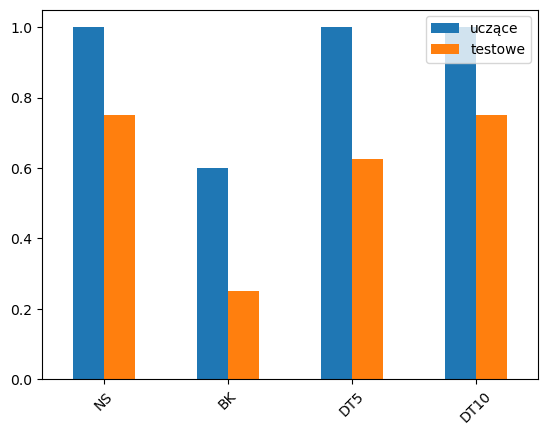

In [144]:
d1 = drop_threshold(data1, 50)
splitd = train_test_data(d1, 0.2, seed=8)
dlearn = tfidf(splitd[0])
dlearn = splitd[0]
print("Klasyfickaja bez stop słów")
respd1 = test_classifier(dlearn, splitd[1], tries=1)
respd1.plot(kind='bar', rot = 45)

Klasyfickaja na stop słowach


<AxesSubplot:>

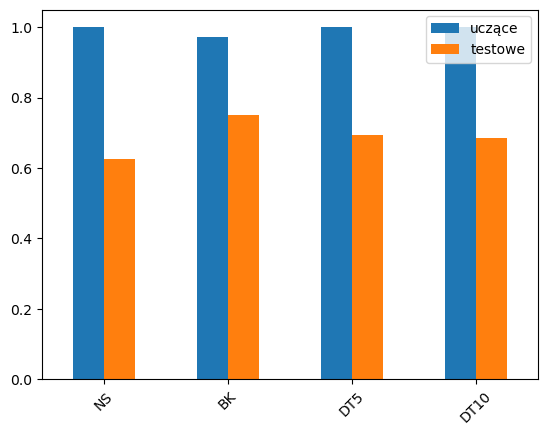

In [156]:
d2 = drop_threshold(data2, 50)
splitd = train_test_data(d2, 0.2, seed=8)
dlearn = frequency(splitd[0])
print("Klasyfickaja na stop słowach")
respd2 = test_classifier(dlearn, splitd[1])
respd2.plot(kind='bar', rot = 45)

Wygląda na to że klasyfikacja z użyciem częstości występowania stop-słów daje lepsze rezultaty niż klasyfikacja po metryka tfidf dla nie-stop słów, należy jednak zauważyć, że skuteczność modelu zależy też od podziału danych na uczące i testowe. Przykładowo, klasyfikacja na podstawie stop-słów dla innej wartości seed:

Klasyfickaja na stop słowach


<AxesSubplot:>

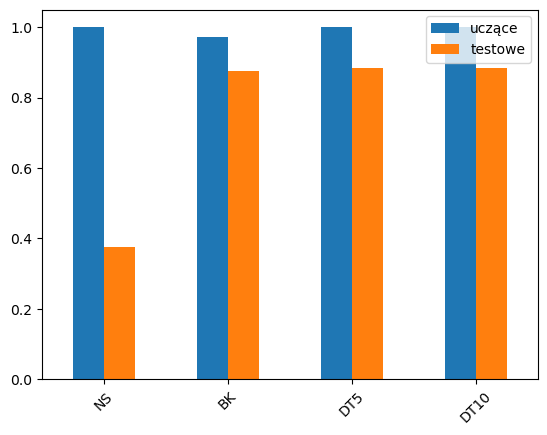

In [158]:
d2 = drop_threshold(data2, 50)
splitd = train_test_data(d2, 0.2, seed=1)
dlearn = frequency(splitd[0])
print("Klasyfickaja na stop słowach")
respd2 = test_classifier(dlearn, splitd[1])
respd2.plot(kind='bar', rot = 45)

Klasyfikacja po stop-słowach kiedy łączymy wszystkie dzieła 1 autora daje jak widać podobne rezultaty.

Klasyfickaja na stop słowach


<AxesSubplot:>

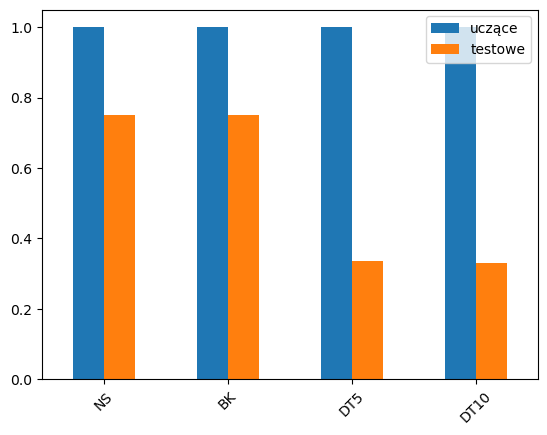

In [160]:
d2 = drop_threshold(data2, 50)
splitd = train_test_data(d2, 0.2, seed=8)
dlearn = merge_author(splitd[0])
dlearn = frequency(dlearn)
print("Klasyfickaja na stop słowach")
respd2 = test_classifier(dlearn, splitd[1])
respd2.plot(kind='bar', rot = 45)

Klasyfickaja bez stop słów


<AxesSubplot:>

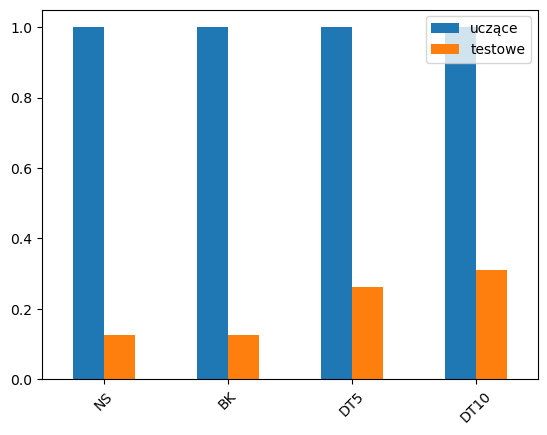

In [170]:
d1 = drop_threshold(data1, 50)
splitd = train_test_data(d1, 0.2, seed=8)
dlearn = merge_author(splitd[0])
dlearn = tfidf(dlearn)
dlearn = dlearn.fillna(0) # nwm czemu się pojawiają
print("Klasyfickaja bez stop słów")
respd1 = test_classifier(dlearn, splitd[1])
respd1.plot(kind='bar', rot = 45)